# Intro to Data Validation with Pandera

In this workshop, we'll learn how to ensure the integrity and reliability of
your data with Pandera.

We'll cover:
- 🤔 Why Data Quality Matters: Understand common data quality challenges and their impact on data-driven applications.
- ✅ Introduction to Pandera: Explore the core concepts of Pandera, including schema definitions, checks, and validation strategies.
- ⭐️ Hands-on Demo: Build real-world data validation pipelines to catch errors early and improve the reliability of your datasets.
- 🔀 Integrating with Workflows: See how Pandera fits into machine learning pipelines, data engineering workflows, and MLOps environments.

In [45]:
!pip install matplotlib numpy pandera pandas scikit-learn scipy seaborn union

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


## 🤔 Why Data Quality Matters

Common data quality challenges:

- Data type errors
- Out-of-range values
- Missing values
- Data drift

Can lead to:
- ⏱️ Hours debugging data pipelines
- 📉 Poor model performance
- ❌ Incorrect reporting and decision-making

### Data type errors

A common data type error is when the column is not the correct type. For example,
we might expect a column to be a datetime, but it's actually a string.

In [13]:
import pandas as pd

dates = ["2025-02-01", "2025-02-02", "2025-02-03"]
dates_df = pd.DataFrame({"dates": dates})
dates_df.head()

,dates
0,2025-02-01
1,2025-02-02
2,2025-02-03


So certain operations may fail unexpectedly.

In [15]:
try:
    dates_df - pd.Timestamp("2025-01-01")
except Exception as e:
    print(e)

unsupported operand type(s) for -: 'numpy.ndarray' and 'Timestamp'


### Out-of-range values

Or columns take on values that are logically impossible, for example, an
inventory dataset may contain the price of items, which can't be negative.

In [17]:
prices = [100, 200, 300, -99999]
prices_df = pd.DataFrame({"prices": prices})
prices_df

,prices
0,100
1,200
2,300
3,-99999


Computing the average price of items in the inventory may be confusing or misleading.

In [19]:
prices_df["prices"].mean()

np.float64(-24849.75)

### Missing values

Long and complex data processing pipelines may lead to missing values, maybe
from an incorrectly written SQL query or another bug somewhere in the code:

In [60]:
housing_df = pd.DataFrame({
    "price": [pd.NA, 200000, 300000, 400000, 500000],
    "bedrooms": [pd.NA, 4, 5, 6, 7],
    "bathrooms": [2, 3, 4, 5, 6],
    "sqft": [2000, 3000, 4000, 5000, 6000],
})
housing_df

,price,bedrooms,bathrooms,sqft
0,<NA>,<NA>,2,2000
1,200000,4,3,3000
2,300000,5,4,4000
3,400000,6,5,5000
4,500000,7,6,6000


In some cases this may be expected due to the inherent nature of the data.

However, in cases where missing values are not expected and are due to bugs in
data processing code, we would want to catch these early before the cause issues
during the model training process.

In [61]:
from sklearn.linear_model import LinearRegression

try:
    model = LinearRegression()
    model.fit(housing_df[["bedrooms", "bathrooms", "sqft"]], housing_df["price"])
    model.predict(housing_df[["bedrooms", "bathrooms", "sqft"]])
except Exception as e:
    print(e)


float() argument must be a string or a real number, not 'NAType'


### Data drift

One of the thorniest problems in machine learning is data drift, where the
distribution of the data changes over time, which can cause the relationship
between features and the target to change. This may lead to model degradation
over time.

Below is an example of two normal distributions of some variable from `t1`
drifting to `t2` over time. The `target` is correlated with `data_t1`, but not
with `data_t2`.

<Axes: ylabel='Frequency'>

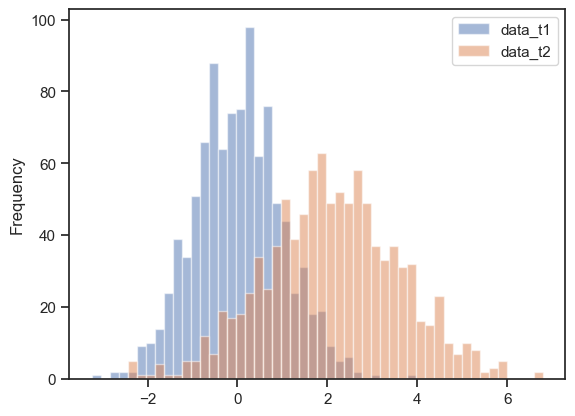

In [55]:
import numpy as np
from scipy import stats

np.random.seed(42)

# Generate two normal distributions with different parameters
n_samples = 1000

data_t1 = stats.norm.rvs(loc=0, scale=1, size=n_samples)
data_t2 = stats.norm.rvs(loc=2, scale=1.5, size=n_samples)

# Create target data that's correlated with data_t1 
# Using a linear relationship with some noise
target = 2 * data_t1 + stats.norm.rvs(loc=0, scale=0.5, size=n_samples)

distributions = pd.DataFrame({
    "data_t1": data_t1,
    "data_t2": data_t2,
    "target": target,
})

distributions[["data_t1", "data_t2"]].plot.hist(bins=50, alpha=0.5)

<Axes: xlabel='data_t2', ylabel='target'>

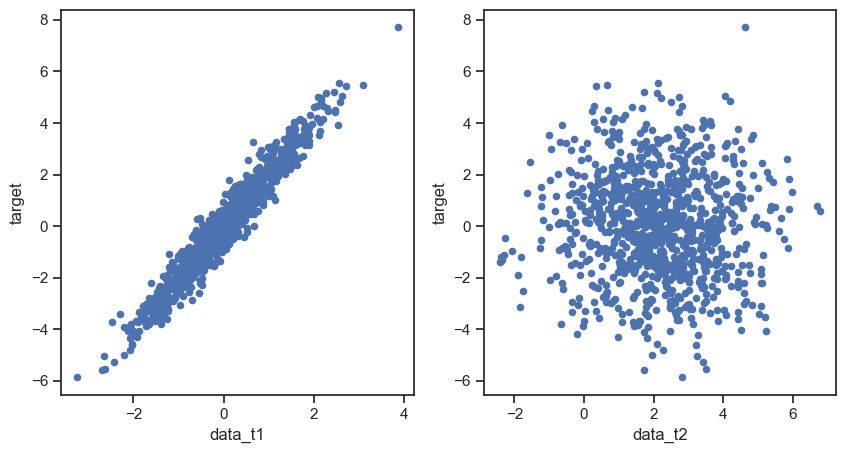

In [56]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
distributions[["data_t1", "target"]].plot.scatter(x="data_t1", y="target", ax=ax[0])
distributions[["data_t2", "target"]].plot.scatter(x="data_t2", y="target", ax=ax[1])

## ✅ Introduction to Pandera

Pandera is a tool for validating data in Python. It provides an easy way to
define data validation rules in Python and apply them on data at runtime.

Let's create a schema for the `housing_df` toy dataset that we created earlier:

In [57]:
housing_df

,price,bedrooms,bathrooms,sqft,location
0,100000,<NA>,2,2000,<NA>
1,200000,4,<NA>,<NA>,LA
2,300000,5,<NA>,4000,NY
3,400000,6,5,5000,TX
4,500000,7,6,6000,FL


First we create a schema for just the data types of each column:

In [58]:
import pandera as pa

class HousingSchema(pa.DataFrameModel):
    price: float
    bedrooms: int
    bathrooms: float
    sqft: int

But that's not all we can do. We can also add value checks to ensure that the
values are within a certain range of allowed values.

In [83]:
class HousingSchema(pa.DataFrameModel):
    price: float = pa.Field(ge=50_000)
    bedrooms: int = pa.Field(ge=1)
    bathrooms: float = pa.Field(ge=1)
    sqft: int = pa.Field(ge=100)

By default, Pandera assumes that missing values are not allowed.

In [85]:
try:
    HousingSchema.validate(housing_df)
except pa.errors.SchemaError as err:
    print(err)


non-nullable series 'price' contains null values:
0    <NA>
Name: price, dtype: object


We'll have to clean the data to make the validation pass. In this case, let's do
the simple thing and remove rows with missing values.

In [86]:
clean_housing_df = housing_df.dropna()
clean_housing_df

,price,bedrooms,bathrooms,sqft
1,200000,4,3,3000
2,300000,5,4,4000
3,400000,6,5,5000
4,500000,7,6,6000


Finally, we can easily create custom validation checks to check for data drift
or other statistical properties.

In [88]:
class HousingSchemaWithCorrelation(pa.DataFrameModel):
    price: float = pa.Field(ge=50_000)
    bedrooms: int = pa.Field(ge=1)
    bathrooms: float = pa.Field(ge=1)
    sqft: int = pa.Field(ge=100)

    @pa.dataframe_check(error="price and all other features must be positively correlated")
    def check_price_correlation(cls, df: pd.DataFrame) -> bool:
        corr_df = df.corr()
        correlated = corr_df["price"].loc[["bedrooms", "bathrooms", "sqft"]] > 0
        return correlated.all()
    
    class Config:
        coerce = True
    
HousingSchemaWithCorrelation.validate(clean_housing_df)

,price,bedrooms,bathrooms,sqft
1,200000.0,4,3.0,3000
2,300000.0,5,4.0,4000
3,400000.0,6,5.0,5000
4,500000.0,7,6.0,6000


In [100]:
corrupted_housing_df = clean_housing_df.copy()
corrupted_housing_df["bedrooms"] = corrupted_housing_df["bedrooms"].tolist()[::-1]

try:
    HousingSchemaWithCorrelation.validate(corrupted_housing_df)
except pa.errors.SchemaError as err:
    print(err)


DataFrameSchema 'HousingSchemaWithCorrelation' failed series or dataframe validator 0: <Check check_price_correlation: price and all other features must be positively correlated>


## ⭐️ Hands-on Demo

In this demo, we're going to see try to protect against a common machine learning
attack: the label-flipping data poisoning attack.

In this attack, an adversary wants to degrade the performance of an ML model by
flipping the labels in a tabular dataset. If the adversary isn't careful about
how they corrupt the data, we can easily catch this kind of attack against a
reference dataset.

## 🔀 Integrating with Workflows

In this final section, we'll see how Pandera can be integrated into a machine
learning orchestrator.

Let's adapt the label-flipping attack demo to a Union workflow, see how
we can catch the attack early, and visualize the error report on the Union UI.

🎉 Congrats! You've learned how to use Pandera to validate data at runtime and
and integrate it with a machine learning orchestrator.